<a href="https://colab.research.google.com/github/strz/ITWILL_Citrus-Tea/blob/master/GoogLeNet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**파이썬 GoogLeNet을 이용한 쯔쯔가무시 등 5종 병변 분류 및 예측**

2020.02.18 (화)
 - 각 클래스당 이미지를 2,000장 부풀려 클래스당 비율을 맞춤.<br>
 (xy_googlenet_1_save.npy: 2,000장 (224,224) 사용)
 - 이미지 제너레이터는 보통수준으로 함(많이 변형하지 않았음).
 - 이미지 파일크기가 250KB 보다 큰 경우, 픽셀 256 비율에 맞게 축소하고,
   작은 경우, 픽셀 224 비율에 맞게 축소하여 부풀림.
 - 모델은 Google net 직접 함수로 구현.


**1. 버전 설정 및 확인**

In [0]:
# Tensorflow 사용버전 설정
%tensorflow_version 1.x

# Tensorflow 버전과 GPU 사용 여부 확인
import tensorflow as tf

print(tf.__version__)
print(tf.test.gpu_device_name()) 

In [0]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

**2. 클래스 및 모듈 import**

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, AveragePooling2D, Flatten, Concatenate, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping , ModelCheckpoint

from keras.engine.saving import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# from image_preporcessing.mj03_2_img_generating_upgrade import img_generating_2, img_to_dataset, labeling, number_of_files

**3. 함수 정의**

In [0]:
def inception(input_tensor, filter_channels):
    """ Inception 모듈 정의
    :param input_tensor: (h,w,n), h와 w는 같은 값이여야함 """
    # 64,(96,128),(16,32),32
    # 출력 피쳐맵의 갯수가 64, 두번째 1x1, 3x3 convolution 연산의 출력 피쳐맵의 갯수는 각각 96,128,
    # 세번째 1x1, 5x5 convolution 연산의 출력 피쳐맵의 갯수는 각각 16,32
    # 마지막 maxpooling 후의 1x1 convolution 연산의 출력 피쳐맵의 갯수는 32 란 의미 이다.
    filter_1x1, filter_3x3_R, filter_3x3, filter_5x5_R, filter_5x5, pool_proj = filter_channels

    branch_1 = Conv2D(filters=filter_1x1, kernel_size=(1, 1), strides=1, padding='same',
                      activation='relu', kernel_initializer='he_normal')(input_tensor)  # He 정규분포 초기값 설정

    branch_2 = Conv2D(filter_3x3_R, (1, 1), strides=1, padding='same',
                      activation='relu', kernel_initializer='he_normal')(input_tensor)
    branch_2 = Conv2D(filter_3x3, (3, 3), strides=1, padding='same',
                      activation='relu', kernel_initializer='he_normal')(branch_2)

    branch_3 = Conv2D(filter_5x5_R, (1, 1), strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal')(input_tensor)
    branch_3 = Conv2D(filter_5x5, (5, 5), strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal')(branch_3)

    branch_4 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_4 = Conv2D(pool_proj, (1, 1), strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal')(branch_4)

    DepthConcat = Concatenate()([branch_1, branch_2, branch_3, branch_4])  # channel last이므로(channel first면 1)

    return DepthConcat



def GoogLeNet(model_input, classes=5):
    # classes=10에서 5로 변경, 5개 중에서 분류할 것이기 때문..
    conv_1 = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(model_input) # (112, 112, 64)
    pool_1 = MaxPooling2D((3, 3), strides=2, padding='same')(conv_1) # (56, 56, 64)
    # LRN_1 = LocalResponseNormalization()(pool_1) # (56, 56, 64) 이걸 BatchNormalization으로 대체함
    BN_1 = BatchNormalization()(pool_1)

    conv_2 = Conv2D(64, (1, 1), strides=1, padding='valid', activation='relu')(BN_1) # (56, 56, 64)
    conv_3 = Conv2D(192, (3, 3), strides=1, padding='same', activation='relu')(conv_2) # (56, 56, 192)
    BN_2 = BatchNormalization()(conv_3) # (56, 56, 192)
    pool_2 = MaxPooling2D((3, 3), strides=2, padding='same')(BN_2) # (28, 28, 192)

    inception_3a = inception(pool_2, [64, 96, 128, 16, 32, 32])  # (28, 28, 256)
    inception_3b = inception(inception_3a, [128, 128, 192, 32, 96, 64])  # (28, 28, 480)

    pool_3 = MaxPooling2D((3, 3), strides=2, padding='same')(inception_3b)  # (14, 14, 480)

    inception_4a = inception(pool_3, [192, 96, 208, 16, 48, 64]) # (14, 14, 512)
    inception_4b = inception(inception_4a, [160, 112, 224, 24, 64, 64]) # (14, 14, 512)
    inception_4c = inception(inception_4b, [128, 128, 256, 24, 64, 64]) # (14, 14, 512)
    inception_4d = inception(inception_4c, [112, 144, 288, 32, 64, 64]) # (14, 14, 528)
    inception_4e = inception(inception_4d, [256, 160, 320, 32, 128, 128]) # (14, 14, 832)

    pool_4 = MaxPooling2D((3, 3), strides=2, padding='same')(inception_4e)  # (7, 7, 832)

    inception_5a = inception(pool_4, [256, 160, 320, 32, 128, 128])  # (7, 7, 832)
    inception_5b = inception(inception_5a, [384, 192, 384, 48, 128, 128])  # (7, 7, 1024)

    avg_pool = GlobalAveragePooling2D()(inception_5b)
    dropout = Dropout(0.4)(avg_pool)

    linear = Dense(512, activation='relu')(dropout) 
    model_output = Dense(classes, activation='softmax', name='main_classifier')(linear)  


    # Auxiliary Classifier - 보조 분류기의 효과는 상대적으로 작다고 들어 빼버림..
    auxiliary_4a = AveragePooling2D((5, 5), strides=3, padding='valid')(inception_4a)
    auxiliary_4a = Conv2D(128, (1, 1), strides=1, padding='same', activation='relu')(auxiliary_4a)
    auxiliary_4a = Flatten()(auxiliary_4a)
    auxiliary_4a = Dense(1024, activation='relu')(auxiliary_4a)
    auxiliary_4a = Dropout(0.7)(auxiliary_4a)
    auxiliary_4a = Dense(classes, activation='softmax', name='auxiliary_4a')(auxiliary_4a)

    auxiliary_4d = AveragePooling2D((5, 5), strides=3, padding='valid')(inception_4d)
    auxiliary_4d = Conv2D(128, (1, 1), strides=1, padding='same', activation='relu')(auxiliary_4d)
    auxiliary_4d = Flatten()(auxiliary_4d)
    auxiliary_4d = Dense(1024, activation='relu')(auxiliary_4d)
    auxiliary_4d = Dropout(0.7)(auxiliary_4d)
    auxiliary_4d = Dense(classes, activation='softmax', name='auxiliary_4d')(auxiliary_4d)

    model = Model(model_input, model_output)
    # model = Model(model_input, [model_output, auxiliary_4a, auxiliary_4d])

    return model

**4. dataset 불러오기 & 전처리**

(생략된 부분 - 이미지 부풀리는 과정)

In [0]:
# np.save('./xy_googlenet_1_save.npy', xy)   # x_save.npy
# 변환 용량이 4기가 이상이면 메모리 오류떠서 아래 프로토콜을 3에서 4로 바꾸고 변환했더니 됨.
# format 파일 -> pickle.dump(array, fp, protocol=4, **pickle_kwargs)

In [0]:
### np.save로 저장된 파일 불러오기
X_train, X_test, y_train, y_test = np.load('./drive/My Drive/final_project/xy_googlenet_1_save.npy', allow_pickle=True)
# xy_googlenet_1_save.npy: 2,000장씩 (224,224)

# 정규화 시키기
X_train = X_train.astype('float16') / 255
X_test = X_test.astype('float16') / 255

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  # X_train: (9144, 224, 224, 3), y_train: (9144, 5)
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')  # X_test: (2287, 224, 224, 3), y_test: (2287, 5)

print(f'X_train: {X_train[0]}, X_test: {X_test[0]}')


### 업그레이드할 때, 정규화 시켜서 저장해놓기 -> 시간이 너무 오래걸림..

**5. 신경망 생성**

In [0]:
### GoogLeNet 모델 만들기 ###

input_shape = (224, 224, 3)  # 이 사이즈로 미리 변환해두었음.
model_input = Input(shape=input_shape)
model = GoogLeNet(model_input=model_input, classes=5)  # class 5개에서 분류
optimizer = SGD(momentum=0.9)

# 계층 요약 확인
model.summary()


In [0]:
# 신경망 모델 컴파일
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
# 신경망 모델의 성능 향상이 없는 경우 중간에 epoch을 빨리 중지시키기 위해서
early_stop = EarlyStopping(monitor='val_loss',
                            verbose=1,
                            patience=10)

# 신경망 학습모델 파일로 저장
model_dir = "./model"
if not os.path.exists(model_dir):  
    os.mkdir(model_dir)

model_path = model_dir + '/googlenet_1.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 신경망 학습
history = model.fit(X_train, y_train,
                    epochs=50,         # 에폭만큼 파라미터 업데이트
                    batch_size=100,    # 전체갯수를 batch_size로 나눈 만큼 반복
                    callbacks=[checkpoint, early_stop],
                    validation_split=0.2)

**6. 신경망 학습 및 평가**

In [0]:
# 테스트 데이터를 사용해서 신경망 모델을 평가
# 테스트 데이터의 Loss, Accuracy
eval = model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]}, accuracy: {eval[1]}')
### 1
# Test loss: 0.567530667542056, accuracy: 0.820288587747623
# Test loss: 0.25168529406326745, accuracy: 0.9156099694443416

# 마지막 값
# - loss: 0.1366 - acc: 0.9444 - val_loss: 0.5462 - val_acc: 0.8141
# Test loss: 0.56544509646045, accuracy: 0.8154787932309616

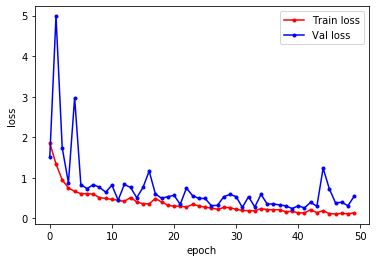

In [11]:
# 학습 데이터와 테스트 데이터의 Loss 그래프
train_loss = history.history['loss']  # history dictionary에 저장된 'loss' 키를 갖는 value들을 가져옴
val_loss = history.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

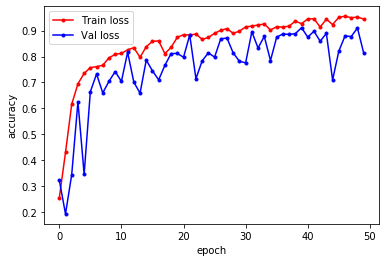

In [12]:
# 학습 데이터, 테스트 데이터의 정확도 그래프
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

x = range(len(train_accuracy))
plt.plot(x, train_accuracy, marker='.', color='red', label='Train loss')
plt.plot(x, val_accuracy, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**7. Confusion matrix**

In [13]:
# # 저장한 학습모델 불러옴.
# model = load_model('./model/.model')

categories = ["df", "mel", "nv", "tsu", "vl"]

# confusion matrix & classification report
print(y_test)

y_true = np.argmax(y_test, axis=1)   # 행 중 가장 큰값의 idx
# (one-hot-encoding 되어있으므로 1로 표시된 값을 행에서 가장 큰값으로 출력하여 array로 만듦)
print(y_true)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(cm)
# 세로가 실제클래스, 가로가 예측클래스

report = classification_report(y_true, y_pred, target_names=categories)
print(report)


[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
[0 3 3 ... 1 1 2]
[0 3 3 ... 1 1 1]
[[262  34 147   1   1]
 [  5 360  76  10   0]
 [  1 105 331   0   1]
 [  5  14   3 507   7]
 [  2   4   4   2 405]]
              precision    recall  f1-score   support

          df       0.95      0.59      0.73       445
         mel       0.70      0.80      0.74       451
          nv       0.59      0.76      0.66       438
         tsu       0.97      0.95      0.96       536
          vl       0.98      0.97      0.97       417

    accuracy                           0.82      2287
   macro avg       0.84      0.81      0.81      2287
weighted avg       0.84      0.82      0.82      2287

